# SRGAN

In [1]:
import os
import time

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from data import DIV2K
from model import srgan
from utils import psnr

from tensorflow.keras.applications.vgg19 import preprocess_input   
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from PIL import Image

%matplotlib inline

In [2]:
os.makedirs('weights/srgan', exist_ok=True)

## Training

### Pre-trained models

If you want to skip training and directly run the demo below, download [weights-srgan.tar.gz](https://drive.google.com/open?id=1u9ituA3ScttN9Vi-UkALmpO0dWQLm8Rv) and extract the archive in the project's root directory. This will create a folder `weights/srgan` containing the weights of the pre-trained models.

### Datasets

You don't need to download the DIV2K dataset as the required parts are automatically downloaded by the `DIV2K` class. By default, DIV2K images are stored in folder `.div2k` in the project's root directory.

In [ ]:
scale = 4
batch_size = 16

In [ ]:
train_x4 = DIV2K(scale=scale, subset='train')
valid_x4 = DIV2K(scale=scale, subset='valid')

In [ ]:
train_x4_ds = train_x4.dataset(batch_size=batch_size, repeat_count=1)
valid_x4_ds = valid_x4.dataset(batch_size=batch_size, repeat_count=1)

### Generator pre-training

In [ ]:
generator = srgan.generator()
generator.compile(optimizer=Adam(lr=1e-4), loss='mean_squared_error', metrics=[psnr])
generator.fit(train_x4_ds, epochs=20000)
generator.save_weights(f'weights/srgan/pre_generator.h5')

### Generator fine-tuning (GAN)

In [ ]:
generator = srgan.generator()
generator_optimizer = Adam()
generator.load_weights('weights/srgan/pre_generator.h5')

discriminator = srgan.discriminator()
discriminator_optimizer = Adam()

In [ ]:
mean_squared_error = tf.keras.losses.MeanSquaredError()

vgg = srgan.vgg_54()

@tf.function
def content_loss(hr, sr):
    sr = preprocess_input(sr)
    hr = preprocess_input(hr)
    sr_features = vgg(sr) / 12.75
    hr_features = vgg(hr) / 12.75
    return mean_squared_error(hr_features, sr_features)

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def generator_loss(sr_out):
    return cross_entropy(tf.ones_like(sr_out), sr_out)

def discriminator_loss(hr_out, sr_out):
    hr_loss = cross_entropy(tf.ones_like(hr_out), hr_out)
    sr_loss = cross_entropy(tf.zeros_like(sr_out), sr_out)
    return hr_loss + sr_loss

In [ ]:
@tf.function
def train_step(lr, hr):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        lr = tf.cast(lr, tf.float32)
        hr = tf.cast(hr, tf.float32)
        
        sr = generator(lr, training=True)

        hr_output = discriminator(hr, training=True)
        sr_output = discriminator(sr, training=True)

        con_loss = content_loss(hr, sr)
        gen_loss = generator_loss(sr_output)
        perc_loss = con_loss + 0.001 * gen_loss
        disc_loss = discriminator_loss(hr_output, sr_output)

    gradients_of_generator = gen_tape.gradient(perc_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return perc_loss, disc_loss

In [ ]:
for learning_rate in [1e-4, 1e-5]:
    generator_optimizer.lr = learning_rate
    discriminator_optimizer.lr = learning_rate
    
    for i in range(2000):
        pls_metric = Mean()
        dls_metric = Mean()
        
        for lr, hr in train_x4_ds:
            pl, dl = train_step(lr, hr)
            pls_metric(pl)
            dls_metric(dl)
        
        print(f'Epoch: {i+1:04d}, lr = {learning_rate:.2e}, perceptual loss = {pls_metric.result():.4f}, discriminator loss = {dls_metric.result():.4f}')

In [ ]:
generator.save_weights(f'weights/srgan/gan_generator.h5')
discriminator.save_weights(f'weights/srgan/gan_discriminator.h5')

## Demo

In [3]:
pre_generator = srgan.generator()
gan_generator = srgan.generator()

pre_generator.load_weights('weights/srgan/pre_generator.h5')
gan_generator.load_weights('weights/srgan/gan_generator.h5')

In [4]:
from model import resolve_single
from utils import load_image

def resolve_and_plot(lr_image_path):
    lr = load_image(lr_image_path)
    
    pre_sr = resolve_single(pre_generator, lr)
    gan_sr = resolve_single(gan_generator, lr)
    
    plt.figure(figsize=(20, 20))
    
    images = [lr, pre_sr, gan_sr]
    titles = ['LR', 'SR (PRE)', 'SR (GAN)']
    positions = [1, 3, 4]
    
    for i, (img, title, pos) in enumerate(zip(images, titles, positions)):
        plt.subplot(2, 2, pos)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])

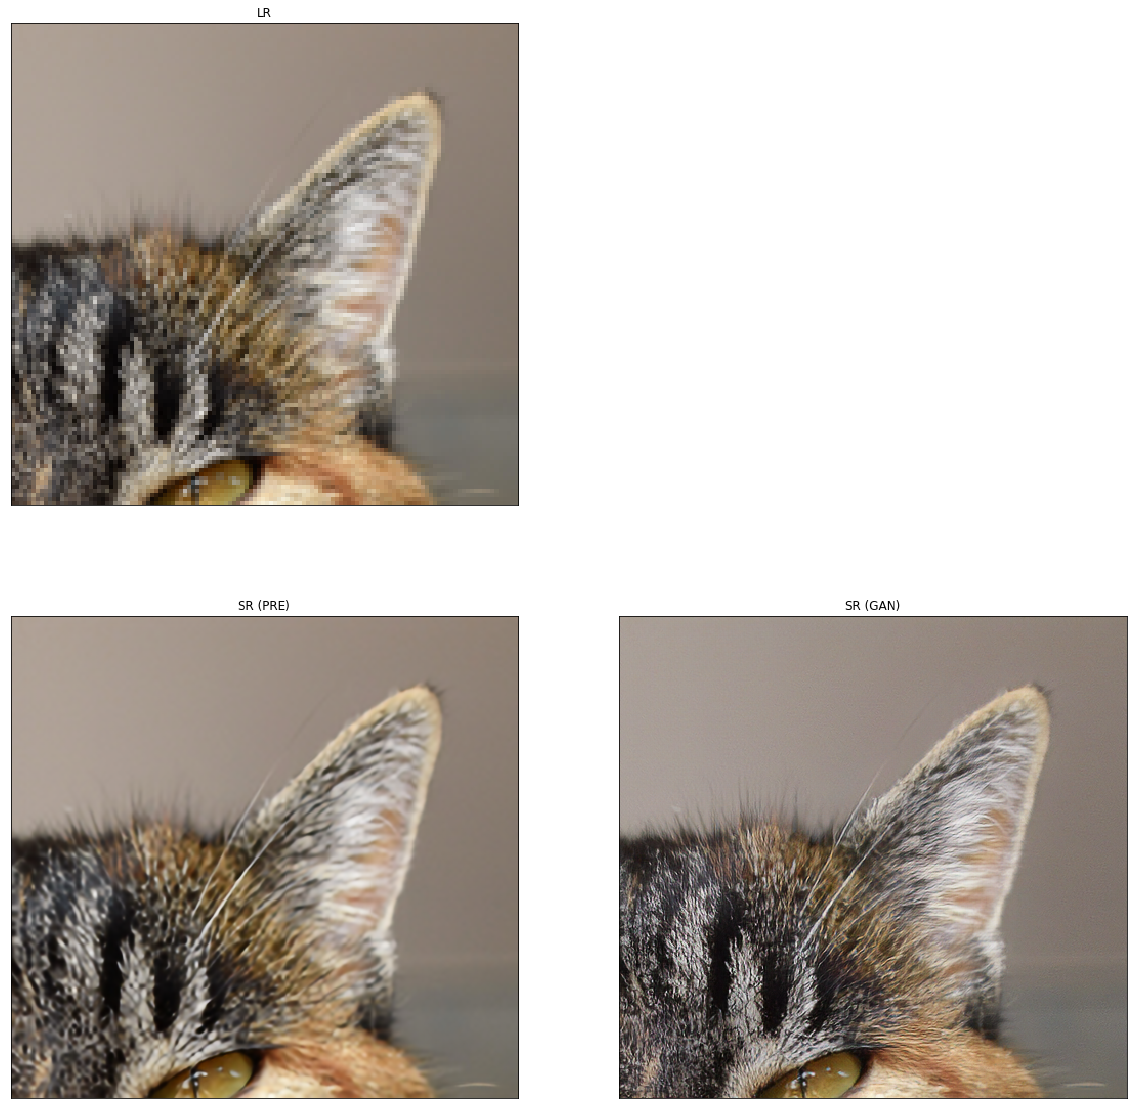

In [5]:
resolve_and_plot('demo/0869x4-crop.png')

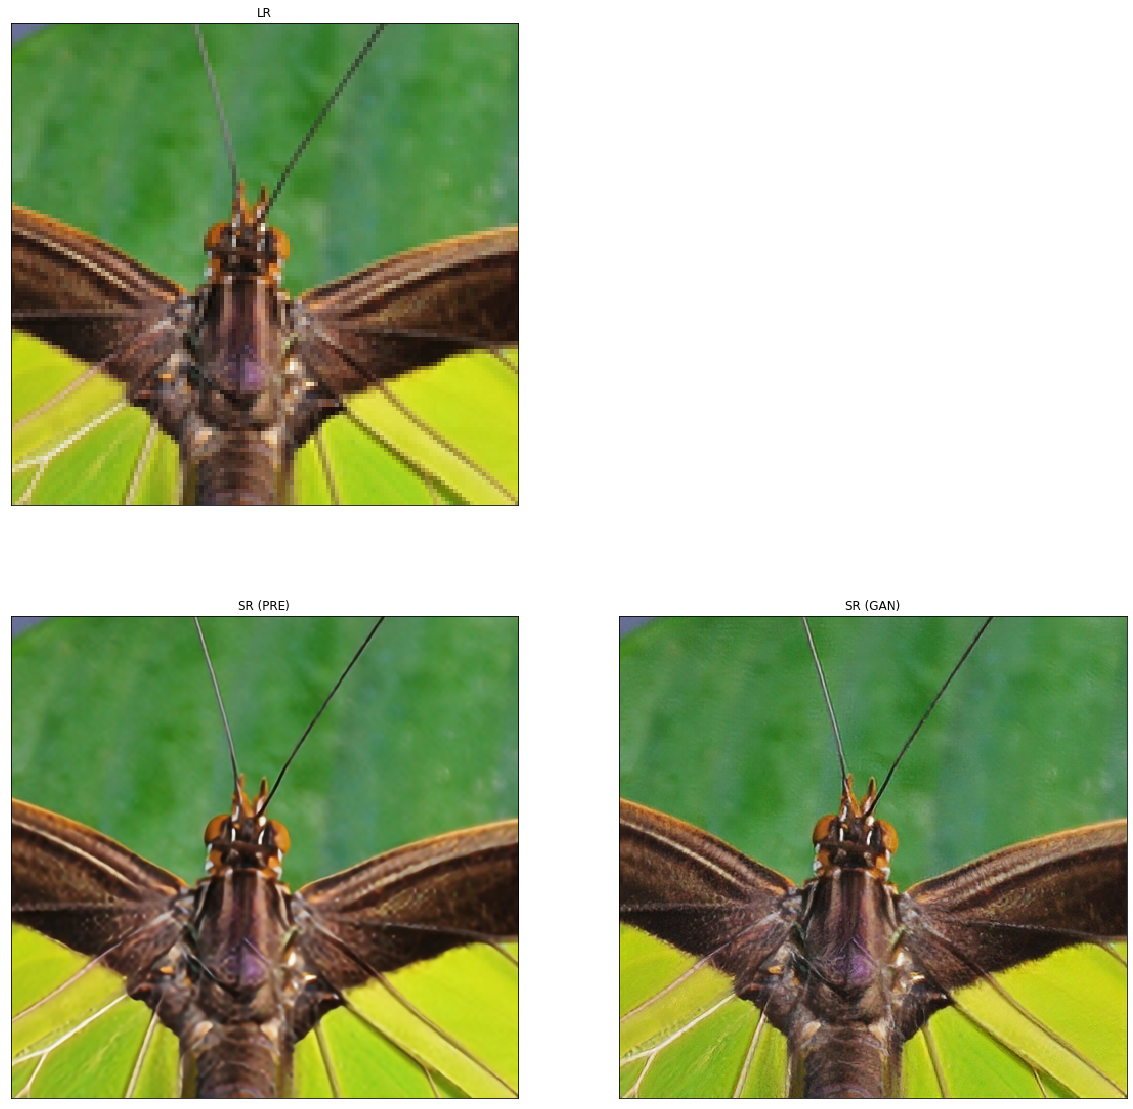

In [6]:
resolve_and_plot('demo/0829x4-crop.png')

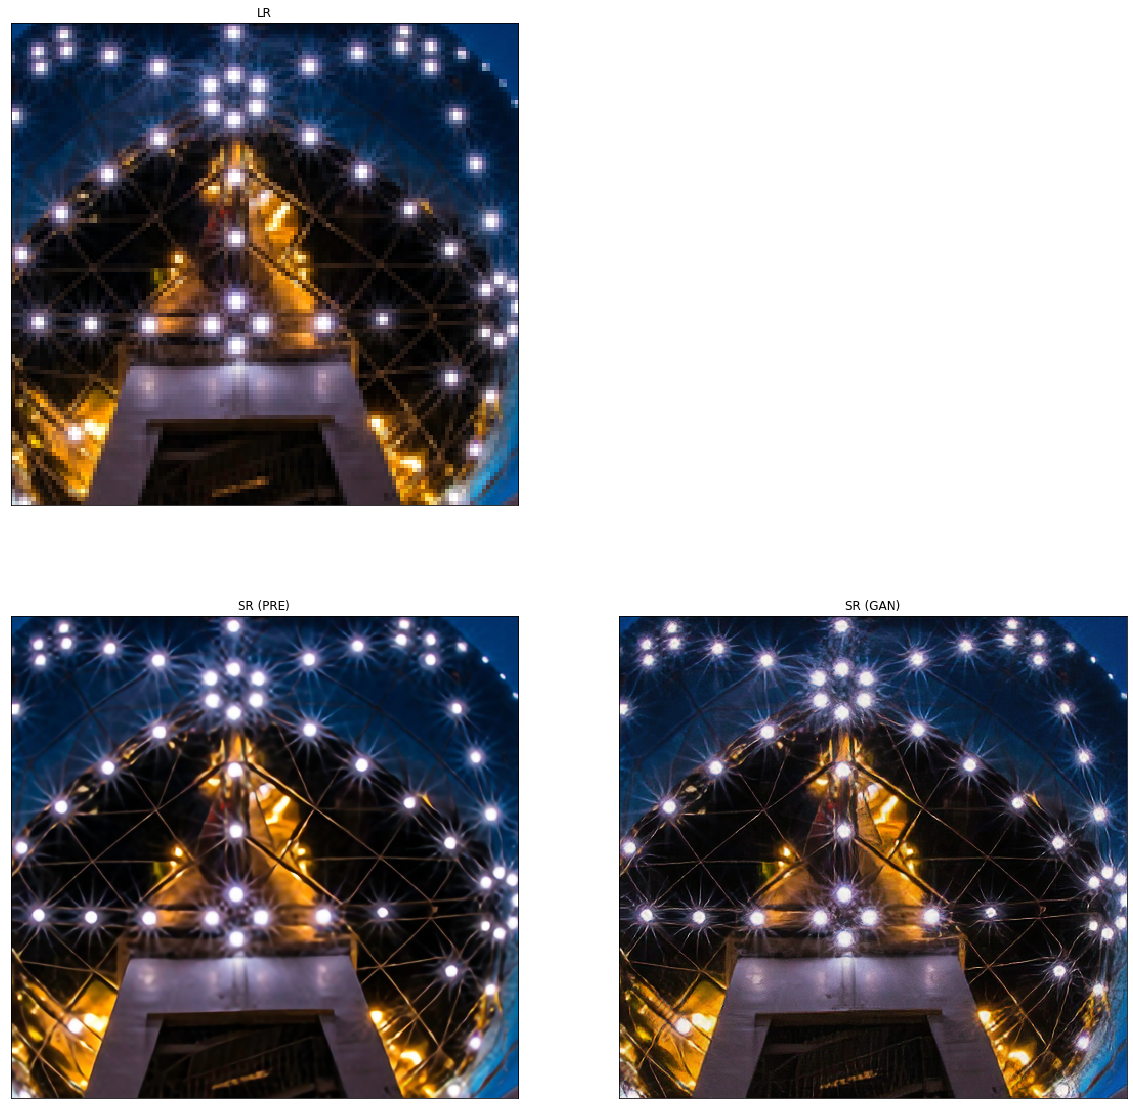

In [7]:
resolve_and_plot('demo/0851x4-crop.png')